# Using the data from Scopus


-  Manual export of a bibtex file.


1. import the bibtex file: get the DOI list
2. Query each doi: populate the store

3. eventually, look for missing references
    - by Query Crossref for the formatted reference resolution: obtain DOI


4. build the graph upward by specifyiing the starting node


In [1]:
import bibtexparser as bib

In [2]:
import crossrefexp as exp

In [3]:
datafile = 'data/citing_Nye1953_journals_short2.bib'

In [14]:
with open(datafile) as bibtex_file:
    bibdata = bib.load(bibtex_file)

scopus_data = {  entry['doi'].lower():entry for entry in bibdata.entries if 'doi' in entry }

print(len(scopus_data))

119


In [15]:
# without a doi:
len( [ entry for entry in bibdata.entries if 'doi' not in entry ] )

10

In [16]:
store = exp.MetaDataStore('data/fromScopus02.pickle')
doi_start = '10.1016/0001-6160(53)90054-6'

1185 metadata loaded from `data/fromScopus02.pickle`


In [17]:
store.query( scopus_data.keys() )

Requesing 119 metadata:
Query performed in 2.617998 s. (92 doi)
Query performed in 0.669215 s. (23 doi)
114 metadata returned for 115 asked
missing doi (1): 10.1007/bf03037803
data/fromScopus02.pickle saved.


In [18]:
doi_list = list( scopus_data.keys()  )

Requesing 4 metadata:..
0 metadata returned for 0 asked
data/fromScopus02.pickle saved.
growth achieved - 442 nodes in the graph. The last generation number is 1.
Requesing 44 metadata:
Query performed in 2.202163 s. (43 doi)
43 metadata returned for 43 asked
data/fromScopus02.pickle saved.
growth achieved - 1770 nodes in the graph. The last generation number is 2.
Requesing 208 metadata:
Query performed in 1.594143 s. (92 doi)
Query performed in 0.936966 s. (92 doi)
Query performed in 0.731033 s. (20 doi)
204 metadata returned for 204 asked
data/fromScopus02.pickle saved.
growth achieved - 6969 nodes in the graph. The last generation number is 3.
graphs/Eisenberg1970Sato200_gen3_top3_noSecondaryLink.svg  saved


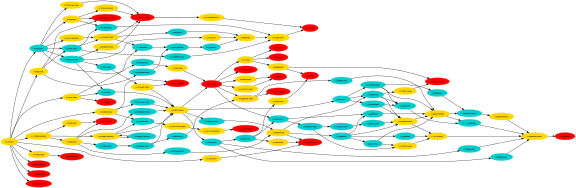

In [26]:
# Build the graph and everything:
gr = store.get_refgraphviz( doi_list, gen=3, starting_from=[doi_start], draw_secondary_links=False )
gr

In [ ]:
missing_refs = []
for doi, scopus_metadata in scopus_data.items():
    metadata = store.get(doi)
    n_refs = metadata.get('references-count')
    metadata_refs = metadata.get('reference', [])
    n_refs_given = len(metadata_refs)
    n_refs_with_doi = len([ref for ref in metadata_refs if 'DOI' in ref ])
    
    n_refs_scopus = len( scopus_data[doi]['references'].split(';') )
    print( n_refs, n_refs_given, n_refs_with_doi, n_refs_scopus )
    
    if n_refs_with_doi>2:
        break
        
doi

In [ ]:
metadata['reference']

exemple of non regex matched doi but existing:

    10.1002/1521-3951(200010)221:2<583::aid-pssb583>3.0.co;2-f



## Retrieving the ref using scopus data
https://www.crossref.org/labs/resolving-citations-we-dont-need-no-stinkin-parser/

input:
- refs with doi from crossref
- ref_text from scopus -> query all -> {doi:metadata}

In [ ]:
import requests
import urllib.parse

In [ ]:
def query_crossref_biblio(ref_text, mailadress=''):
    """ Query Crossref for the given formatted reference text."""
    
    print( 'Query for "{}..."'.format( ref_text[:60] ), end='\r' )
    minimum_score_required = 40
    
    url = "https://api.crossref.org/works"

    params = {'mailto': mailadress,
              'query.bibliographic':ref_text}

    response = requests.get(url, params=params)
    
    if not response.ok:
        print('query error: %s' % response.content)
    else:
       
        r = response.json()
        items = r['message']['items']

        sorted_match = sorted( items, key=lambda x:x['score'], reverse=True )
        best_match = sorted_match[0]
        
        print( ' '*80, end='\r' )
        print( 'Query answered in {:3f} s. Score: {}'.format( response.elapsed.total_seconds(), best_match['score'] ) )
    
    
    if best_match['score'] > minimum_score_required:
        return best_match
    else:
        return None


In [ ]:
bib_metadata = bibdata.entries[2]

In [ ]:
doi = bib_metadata['doi']
doi

In [ ]:
references = bib_metadata['references'].split(';')
references = [ ref.strip() for ref in references ]
print('\n'.join(references))


references_doi = []

for ref_text in references:
    best_match = query_crossref_biblio( ref_text )

    if best_match:
        match_doi = best_match['DOI']
        references_doi.append(match_doi)
        
        if match_doi not in store:
            store[match_doi] = best_match
            

In [ ]:
len( references_doi )

In [ ]:
metadata = store[doi]

In [ ]:
metadata['references-count']

In [ ]:
ref_text = references[12]

best_match = query_crossref_biblio( ref_text )
best_match